# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **8p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *6p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning **2p**
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. *2p*
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - RÂ² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Data Loading

Vom split-ui datasetul de train in 90% train si 10% validation

In [114]:
x_train = pd.read_csv("X_train.csv").values
x_test = pd.read_csv("X_test.csv").values

y_train = pd.read_csv("Y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print("Updated Data Shapes:")
print("Train:", x_train.shape, y_train.shape)
print("Validation:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)



Updated Data Shapes:
Train: (21699, 40) (21699,)
Validation: (2412, 40) (2412,)
Test: (6028, 40) (6028,)


### Verificare distributie variabila target

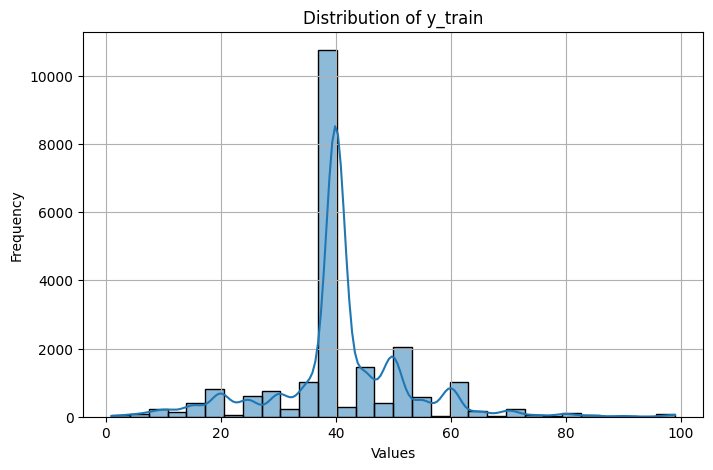

In [115]:
plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True, bins=30)  
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of y_train')
plt.grid(True)
plt.show()

Se observa ca predominant in dataset se gasesc oameni care lucreaza 40 de ore. Bazandu-ma pe date si pe ideea ca un model care ar returna mereu 40 s-ar descurca foarte bine, o prima idee este sa testam un astfel de model. Pe parcurs, o sa evaluez modelele pe baza MSE, MAE, RMSE si $R^2$. Am ales MSE si respectiv RMSE pentru a observa performanta modelului fata de valorile departate de 40h. MAE a fost aleasa pentru a compara Baseline ul care ar trebui sa aiba un MAE bun cu celelalte modele (concentrarea gigantica de valori in 40). Iar R patrat a fost ales pentru a putea face distinctia intre modelele lineare si non lineare, pentru a vedea care din ele explica mai bine variatia.

In [116]:
y_pred_baseline = np.full_like(y_val, fill_value=40)

mse_baseline = mean_squared_error(y_val, y_pred_baseline)
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_val, y_pred_baseline)

print("Baseline Model Performance (Always Predict 40):")
print(f"MSE: {mse_baseline:.2f}, MAE: {mae_baseline:.2f}, RMSE: {rmse_baseline:.2f}, RÂ²: {r2_baseline:.4f}")


Baseline Model Performance (Always Predict 40):
MSE: 143.26, MAE: 7.22, RMSE: 11.97, RÂ²: -0.0058


Ce observam din rezultatul modelului e ca MAE este relativ mic, in schimb MSE este relativ mare, ceea ce indica faptul ca ar trebui sa ne concentram pe MSE. In acelasi timp, faptul ca R patrat este negativ, ne convinge ca modelul nu explica variatia datelor. In continuare, voi testa atat modele liniare - SGD Regression si Linear Regression, cat si Decision Tree si Random Forest.

In [117]:
sgd_model = SGDRegressor(
    max_iter=5000,       
    tol=1e-5,            
    penalty='l2',        
    alpha=0.0001,        
    learning_rate='adaptive',
    eta0=0.001,
    random_state=42
)

sgd_model.fit(x_train, y_train)
y_pred_sgd = sgd_model.predict(x_val)

mse_sgd = mean_squared_error(y_val, y_pred_sgd)
mae_sgd = mean_absolute_error(y_val, y_pred_sgd)
rmse_sgd = np.sqrt(mse_sgd)
r2_sgd = r2_score(y_val, y_pred_sgd)

print(f"SGDRegressor Performance:\nMSE: {mse_sgd:.2f}, MAE: {mae_sgd:.2f}, RMSE: {rmse_sgd:.2f}, RÂ²: {r2_sgd:.4f}")


SGDRegressor Performance:
MSE: 116.10, MAE: 7.52, RMSE: 10.78, RÂ²: 0.1849


In [118]:
lr_model = LinearRegression()

lr_model.fit(x_train, y_train)

y_pred_lr = lr_model.predict(x_val)

mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_val, y_pred_lr)

print(f"Linear Regression Performance:\nMSE: {mse_lr:.2f}, MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, RÂ²: {r2_lr:.4f}")


Linear Regression Performance:
MSE: 115.91, MAE: 7.52, RMSE: 10.77, RÂ²: 0.1862


In [119]:
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  

tree_model.fit(x_train, y_train)

y_pred_tree = tree_model.predict(x_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y_val, y_pred_tree)

print(f"Decision Tree Performance:\nMSE: {mse_tree:.2f}, MAE: {mae_tree:.2f}, RMSE: {rmse_tree:.2f}, RÂ²: {r2_tree:.4f}")


Decision Tree Performance:
MSE: 109.13, MAE: 7.17, RMSE: 10.45, RÂ²: 0.2338


In [120]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_val)

mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print(f"Random Forest Performance:\nMSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, RÂ²: {r2_rf:.4f}")


Random Forest Performance:
MSE: 105.28, MAE: 6.99, RMSE: 10.26, RÂ²: 0.2609


### Experiment Results Table

| Model                           | MSE   | MAE  | RMSE  | RÂ²    |
|---------------------------------|-------|------|-------|-------|
| **Baseline (Always Predict 40)** | 143.26 | 7.22 | 11.97 | -0.0058 |
| **SGDRegressor**                 | 116.10 | 7.52 | 10.78 | 0.1849  |
| **Linear Regression**            | 115.91 | 7.52 | 10.77 | 0.1862  |
| **Decision Tree**                | 109.13 | 7.17 | 10.45 | 0.2338  |
| **Random Forest**                | **105.28** | **6.99** | **10.26** | **0.2609** |



Modele non liniare se descurca mai bine decat cele liniare, ceea ce indica non liniaritate in variatia datelor. Cel mai bun model e Random Forest deoarece are toate valorile scazute, mai putin R patrat pe care il vrem cat mai mare. Decision Trees nu au nevoie de one hot encoding iar Random Forest pot avea o performanta scazuta din aceasta cauza. Astfel vom combina coloanele pentru a reveni la un label encoding.

### Data Load & Cleaning for multiple preprocessed datasets

In [121]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]


In [122]:
data_set_dt = pd.read_csv(data_url, header=None, names=columns, na_values="?", skipinitialspace=True)
data_set_dt.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [123]:
def detect_missing_values(dataframe):
    missing_counts = dataframe.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    missing_percent = (missing_counts / len(dataframe)) * 100
    return pd.DataFrame({"Missing Count": missing_counts, "Missing Percent": missing_percent})

print(detect_missing_values(data_set_dt))

                Missing Count  Missing Percent
workclass                1836         5.638647
occupation               1843         5.660146
native-country            583         1.790486


In [124]:
def drop_missing_values(data, columns):
    return data.dropna(subset=columns)

data = drop_missing_values(data_set_dt, ["workclass", "occupation", "native-country"])

print(detect_missing_values(data))

print(f"New dataset shape after dropping missing values: {data.shape}")

Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []
New dataset shape after dropping missing values: (30162, 15)


In [125]:
def detect_duplicates(data):
    print(f"Number of duplicate rows: {data.duplicated().sum()}")
    return data[data.duplicated()]

duplicates = detect_duplicates(data)

print(duplicates.head())


Number of duplicate rows: 23
       age workclass  fnlwgt     education  education-num marital-status  \
4881    25   Private  308144     Bachelors             13  Never-married   
5104    90   Private   52386  Some-college             10  Never-married   
9171    21   Private  250051  Some-college             10  Never-married   
11631   20   Private  107658  Some-college             10  Never-married   
13084   25   Private  195994       1st-4th              2  Never-married   

            occupation   relationship                race     sex  \
4881      Craft-repair  Not-in-family               White    Male   
5104     Other-service  Not-in-family  Asian-Pac-Islander    Male   
9171    Prof-specialty      Own-child               White  Female   
11631     Tech-support  Not-in-family               White  Female   
13084  Priv-house-serv  Not-in-family               White  Female   

       capital-gain  capital-loss  hours-per-week native-country income  
4881              0      

In [126]:
data = data.drop_duplicates()

print(f"Remaining duplicate rows: {data.duplicated().sum()}")
print(f"Final dataset shape: {data.shape}")

Remaining duplicate rows: 0
Final dataset shape: (30139, 15)


In [127]:
def fix_inconsistencies(data):
    for col in data.select_dtypes(include='object'):
        data[col] = data[col].str.strip().str.lower()
    return data

data = fix_inconsistencies(data)

In [128]:
data = data.drop(columns=["fnlwgt", "native-country", "capital-gain", "capital-loss", "occupation"], errors="ignore")

In [ ]:
target_col = "hours-per-week"

X = data.drop(columns=[target_col])  
y = data[target_col]  

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=42)
x_train_dt, x_val_dt, y_train_dt, y_val_dt = train_test_split(x_train_dt, y_train_dt, test_size=0.1, random_state=42)

print(f"X_train shape: {x_train_dt.shape}, X_test shape: {x_test_dt.shape}")
print(f"y_train shape: {y_train_dt.shape}, y_test shape: {y_test_dt.shape}")

ðŸ“Œ X_train shape: (21699, 9), X_test shape: (6028, 9)
ðŸ“Œ y_train shape: (21699,), y_test shape: (6028,)


Outliers BEFORE IQR capping:


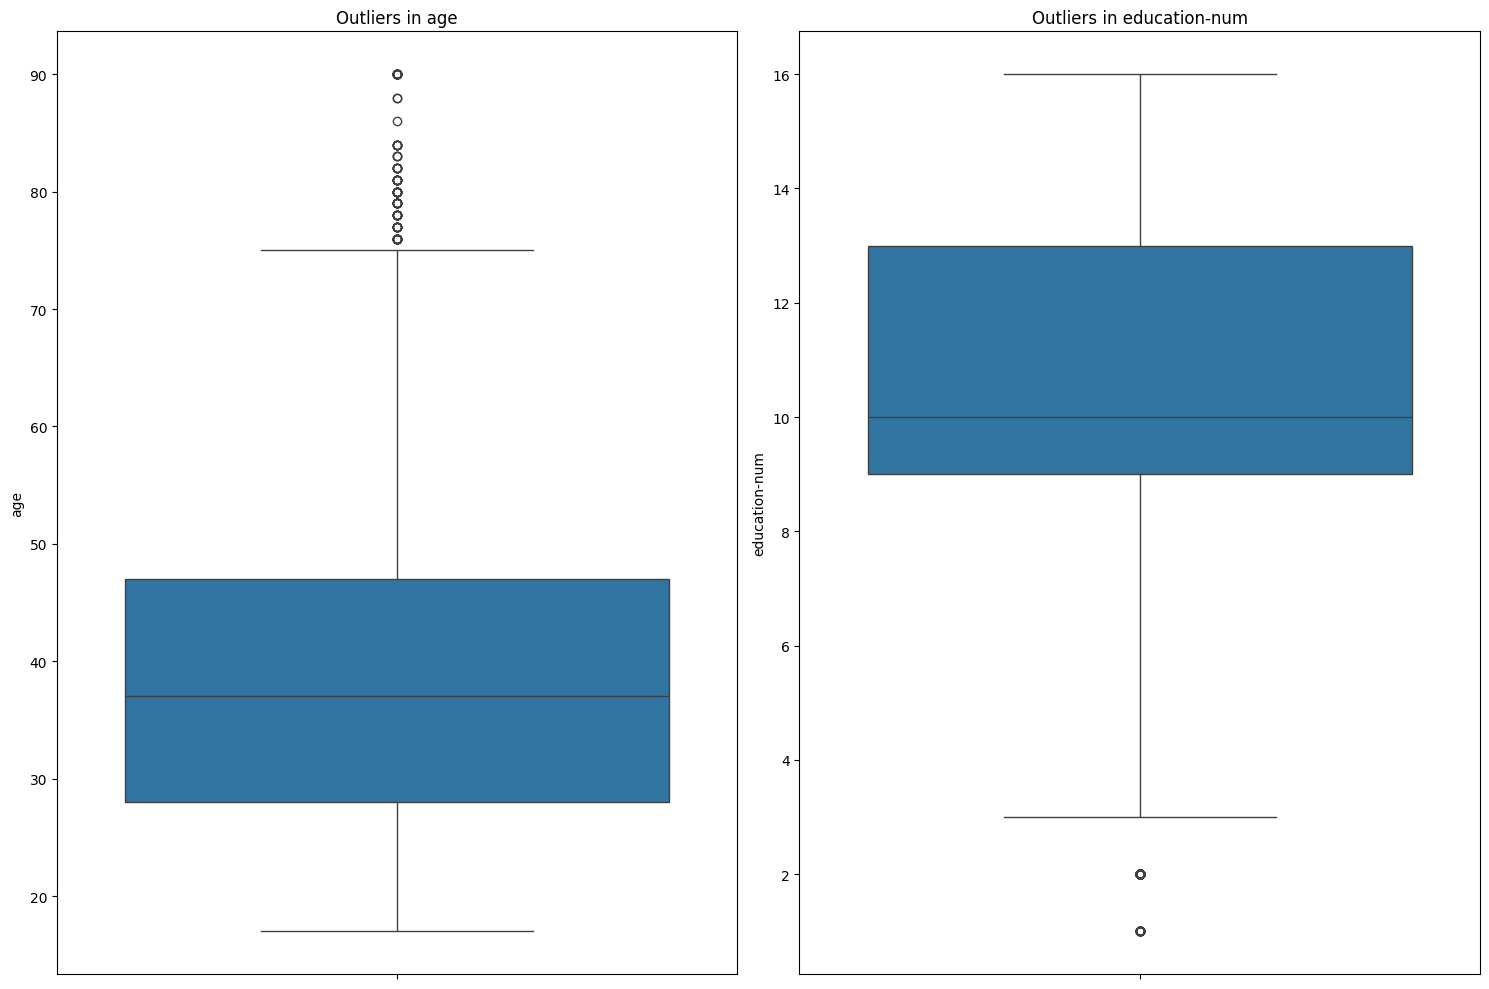

In [130]:
def plot_outliers(data, numeric_cols):
    """
    Plots boxplots for all numerical columns to visualize outliers.

    Parameters:
    - data: DataFrame containing numeric columns
    - numeric_cols: List of numeric column names
    """
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot((len(numeric_cols) + 1) // 2, 2, i)
        sns.boxplot(y=data[col])
        plt.title(f"Outliers in {col}")
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

numeric_cols = x_train_dt.select_dtypes(include=[np.number]).columns

print("Outliers BEFORE IQR capping:")
plot_outliers(x_train_dt, numeric_cols)

Outliers AFTER IQR capping:


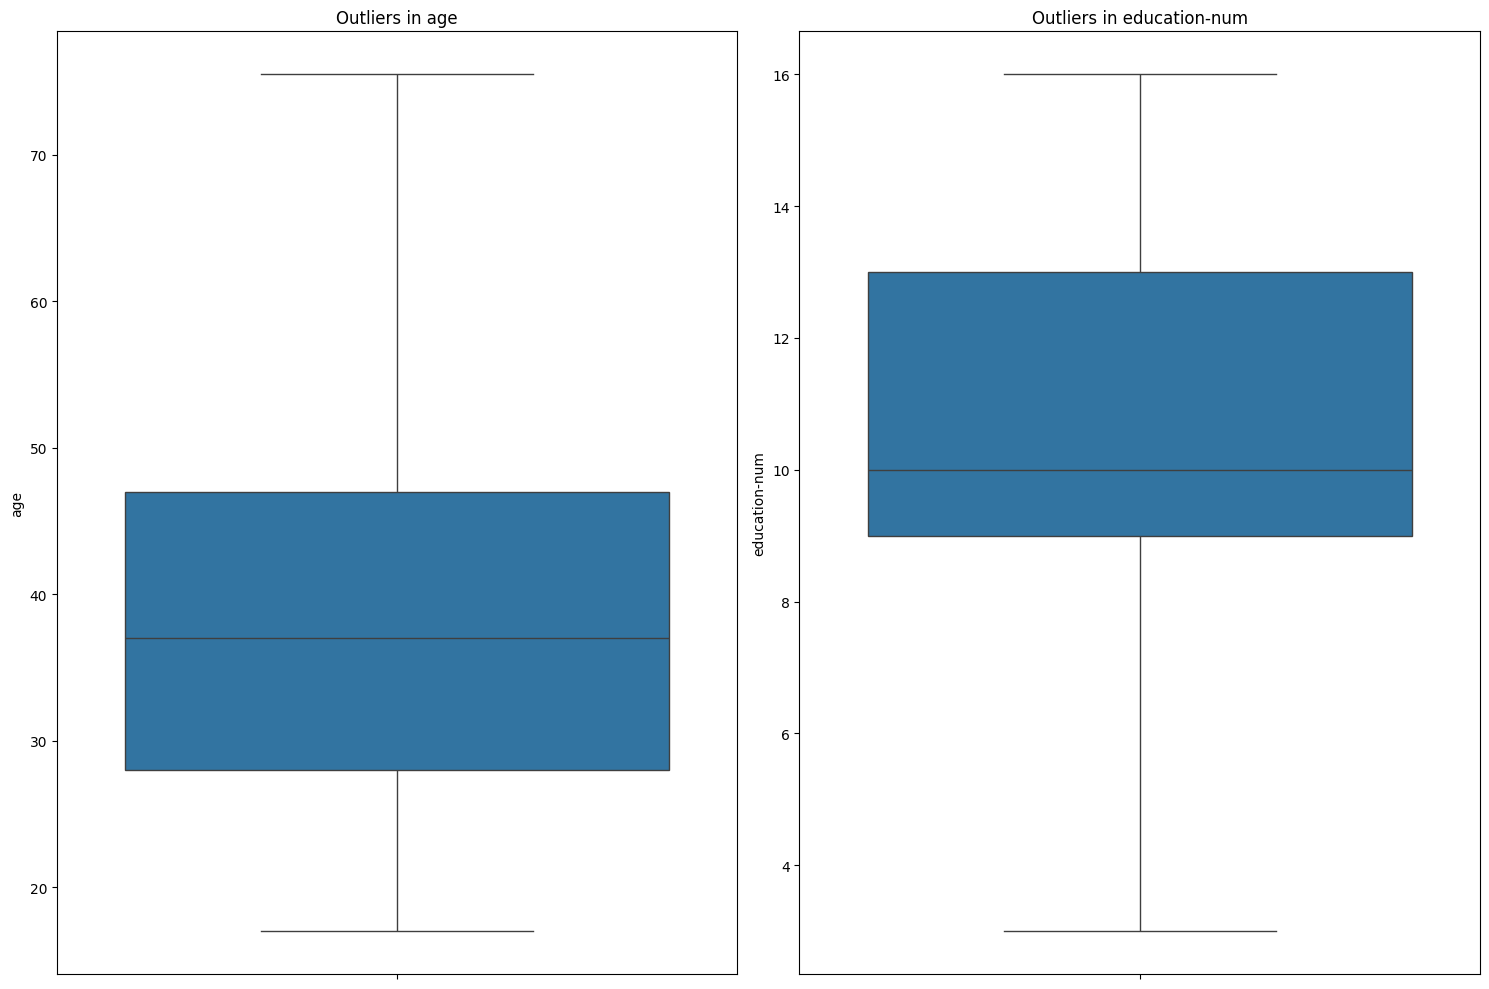

In [131]:
def cap_outliers_with_train(train, test, numeric_cols):
    """
    Applies IQR capping to numerical columns in training and testing sets.

    Parameters:
    - train: DataFrame containing training features
    - test: DataFrame containing testing features
    - numeric_cols: List of numerical feature column names (excluding target)
    
    Returns:
    - Updated train and test DataFrames with capped outliers
    """
    for column in numeric_cols:
        Q1 = train[column].quantile(0.25)
        Q3 = train[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        train[column] = train[column].clip(lower=lower_bound, upper=upper_bound)
        test[column] = test[column].clip(lower=lower_bound, upper=upper_bound)

    return train, test

numeric_cols = [col for col in x_train_dt.select_dtypes(include=[np.number]).columns if col != "hours-per-week"]

x_train_dt, x_test_dt = cap_outliers_with_train(x_train_dt, x_test_dt, numeric_cols)

print("Outliers AFTER IQR capping:")
plot_outliers(x_train_dt, numeric_cols)

In [132]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country", "sex", "income"]

label_encoders = {}

for col in categorical_cols:
    if col in x_train_dt.columns:
        le = LabelEncoder()
        x_train_dt[col] = le.fit_transform(x_train_dt[col])
        x_test_dt[col] = le.transform(x_test_dt[col])  # Use the same encoder for test set
        x_val_dt[col] = le.transform(x_val_dt[col])
        label_encoders[col] = le  # Save encoders for future reference

Calculating Feature Importance using Random Forest...


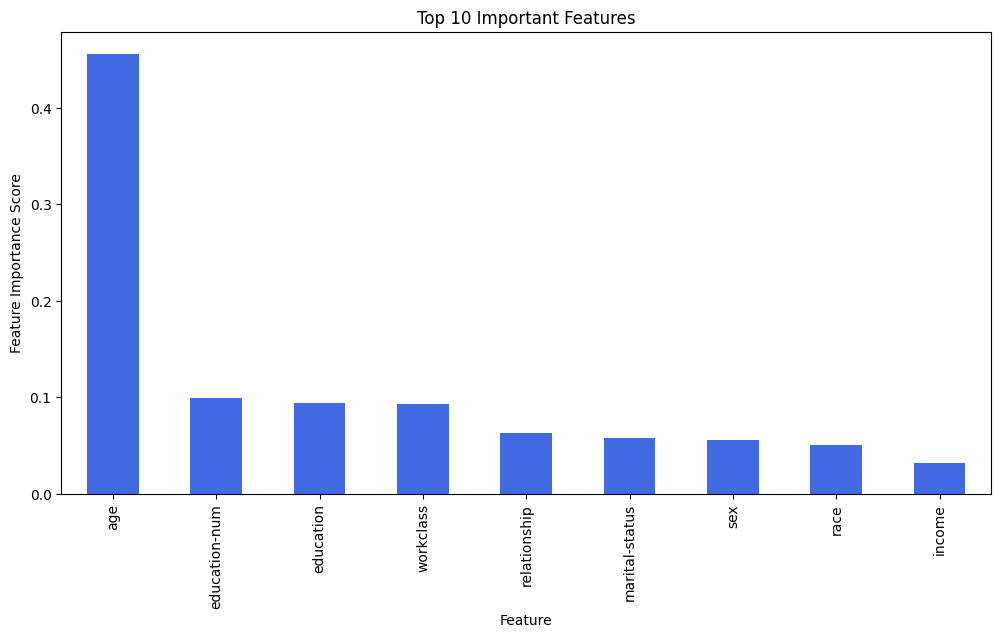

Checking for Highly Correlated Features...


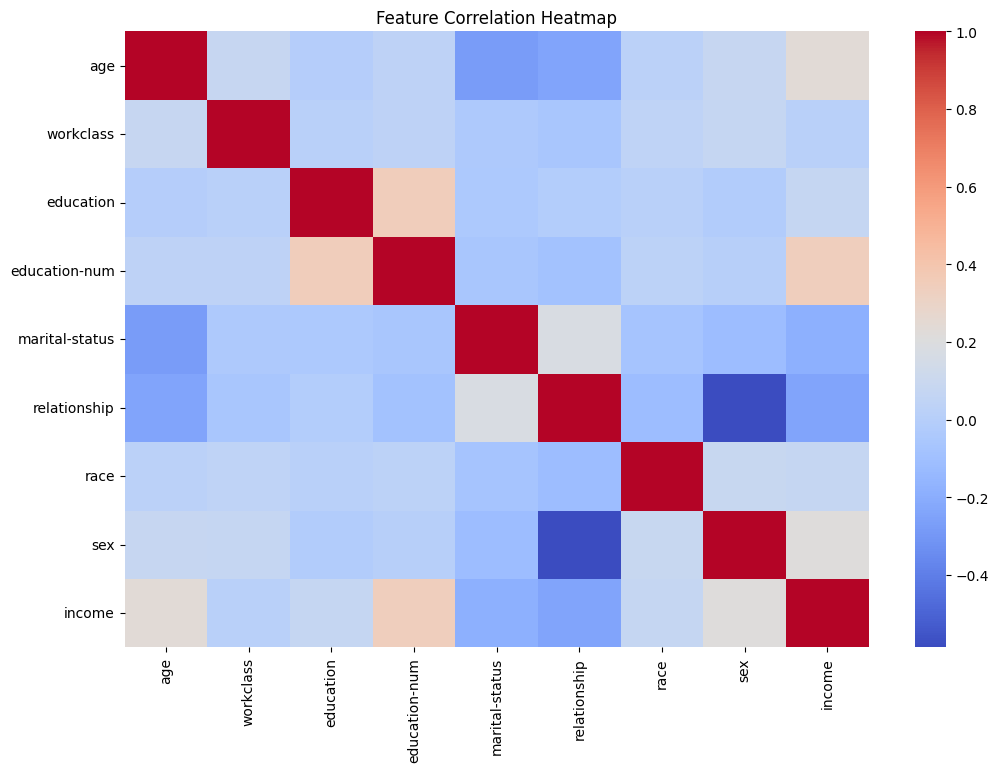

Highly Correlated Features (corr > 0.9): []
Checking Categorical Feature Distribution...


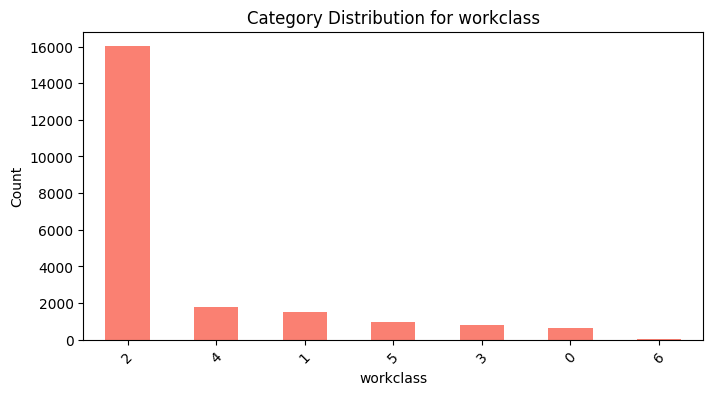

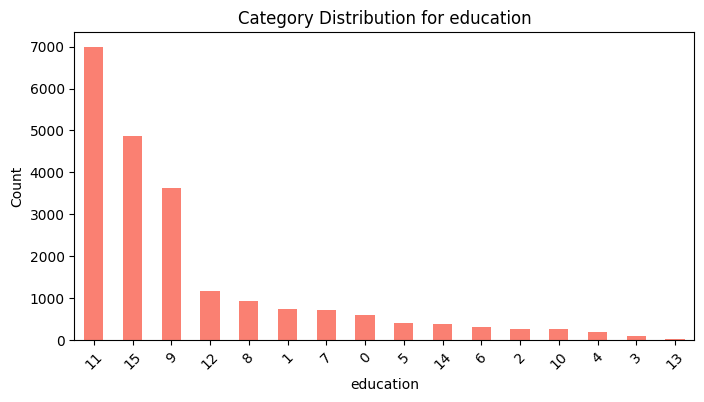

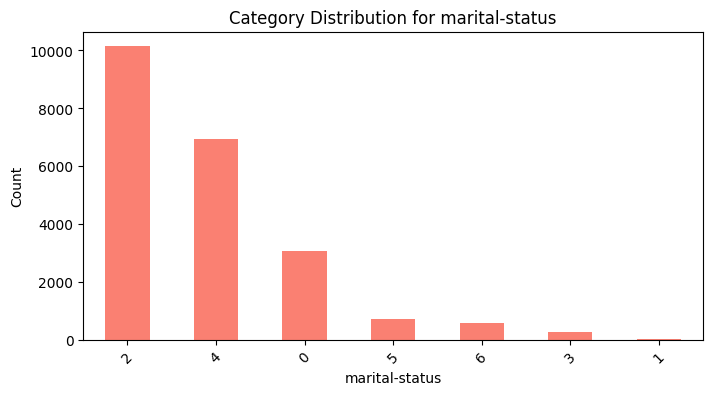

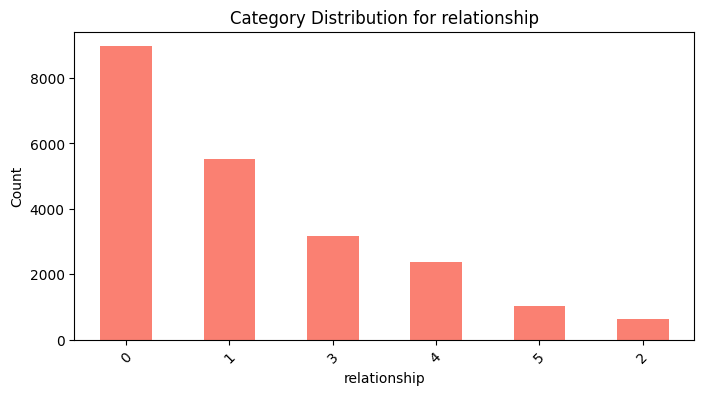

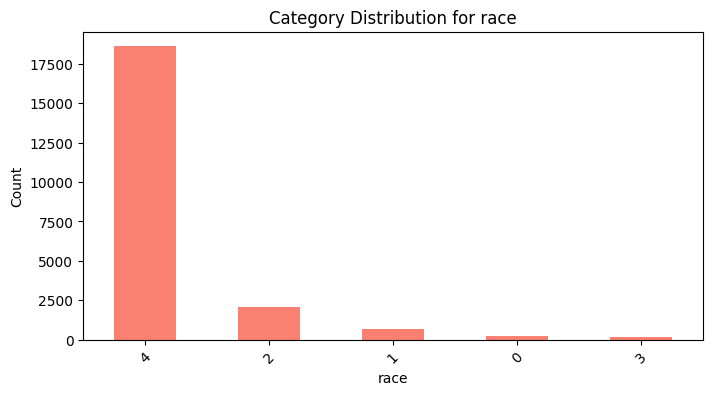

 Summary of Feature Analysis:
 Most Important Features: ['age', 'education-num', 'education', 'workclass', 'relationship', 'marital-status', 'sex', 'race', 'income']
 Features with High Correlation (> 0.9): []
 Consider removing correlated or unimportant features and re-running the model.


In [133]:
from sklearn.ensemble import RandomForestRegressor

print("Calculating Feature Importance using Random Forest...")

rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(x_train_dt, y_train_dt)


feature_importances = pd.Series(rf_temp.feature_importances_, index=x_train_dt.columns)
feature_importances = feature_importances.sort_values(ascending=False)


plt.figure(figsize=(12, 6))
feature_importances[:10].plot(kind='bar', color='royalblue')
plt.title("Top 10 Important Features")
plt.ylabel("Feature Importance Score")
plt.xlabel("Feature")
plt.show()

print("Checking for Highly Correlated Features...")
correlation_matrix = x_train_dt.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

high_corr_features = set()
corr_threshold = 0.9  

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print(f"Highly Correlated Features (corr > {corr_threshold}): {list(high_corr_features)}")

print("Checking Categorical Feature Distribution...")
categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country"]

for col in categorical_cols:
    if col in x_train_dt.columns:
        plt.figure(figsize=(8, 4))
        x_train_dt[col].value_counts().plot(kind='bar', color='salmon')
        plt.title(f"Category Distribution for {col}")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()

print(" Summary of Feature Analysis:")
print(f" Most Important Features: {list(feature_importances[:10].index)}")
print(f" Features with High Correlation (> {corr_threshold}): {list(high_corr_features)}")
print(f" Consider removing correlated or unimportant features and re-running the model.")


### Models with Additional Preprocessed Datasets

In [134]:
important_features = ['age', 'education-num', 'education', 'workclass', 'relationship', 'marital-status', 'sex', 'race', 'income']
x_train_dt_sparse = x_train_dt[important_features]
x_test_dt_sparse = x_test_dt[important_features]
x_val_dt_sparse = x_val_dt[important_features]

In [135]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train_dt, y_train_dt)

y_pred_rf = rf_model.predict(x_val_dt)

mse_rf = mean_squared_error(y_val_dt, y_pred_rf)
mae_rf = mean_absolute_error(y_val_dt, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val_dt, y_pred_rf)

print(f"Random Forest Performance:\nMSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, RÂ²: {r2_rf:.4f}")

Random Forest Performance:
MSE: 105.26, MAE: 7.01, RMSE: 10.26, RÂ²: 0.2610


In [136]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(x_train_dt_sparse, y_train_dt)

y_pred_rf = rf_model.predict(x_val_dt_sparse)

mse_rf = mean_squared_error(y_val_dt, y_pred_rf)
mae_rf = mean_absolute_error(y_val_dt, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_val_dt, y_pred_rf)

print(f"Random Forest Performance:\nMSE: {mse_rf:.2f}, MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, RÂ²: {r2_rf:.4f}")

Random Forest Performance:
MSE: 105.29, MAE: 7.01, RMSE: 10.26, RÂ²: 0.2608


Dupa ce am creat un model Random Decision Forest pe datele preprocesate, aplicand hot encoding, am decis sa realizez inca doua experimente. Primul experiment a fost construit utilizand toate caracteristicile, dar fara standardizare si fara hot encoding, deoarece Random Forest nu necesita aceste transformari, ci doar label encoding. Al doilea experiment a presupus antrenarea unui model folosind doar cele mai importante caracteristici selectate. Rezultatele obtinute au fost similare cu cele ale primului model, fara diferente semnificative in performanta.

### Random Forest Performance Comparison

| Model | MSE   | MAE  | RMSE  | RÂ²    | Notes |
|-----------------------------|-------|------|-------|-------|------------------------------------------------|
| **With Standardization & One-Hot Encoding (All Features)** | 105.28 | 6.99 | 10.26 | 0.2609 | Preprocessed Data (Standardized + One-Hot Encoded) |
| **Without Standardization & One-Hot Encoding (All Features)** | 105.26 | 7.01 | 10.26 | 0.2610 | Cleaned Data + Label Encoding (No Standardization) |
| **Without Standardization & One-Hot Encoding (Most Important Features)** | 105.29 | 7.01 | 10.26 | 0.2608 | Cleaned Data + Label Encoding (No Standardization) + Feature Selection |




In [137]:
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [5, 10, 15],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5]  
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred_best_rf = best_rf.predict(x_test)

mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Optimized Random Forest Performance:")
print(f"MSE: {mse_best_rf:.2f}, MAE: {mae_best_rf:.2f}, RMSE: {rmse_best_rf:.2f}, RÂ²: {r2_best_rf:.4f}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Performance:
MSE: 109.71, MAE: 7.14, RMSE: 10.47, RÂ²: 0.2425


## Concluzii


### Pasi urmati

ðŸ“Œ Preprocesarea datelor
Am inceput prin curatarea setului de date: eliminarea valorilor lipsa, a duplicatelor si a eventualelor inconsistente. Dupa am identificat si "tratat" outliers folosind metoda IQR. Pentru primul set de date, am folosit atat manual encoding (coloanele sex si income), cat si one hot encoding. Acest set de date a fost impartit in train si test (80-20).

ðŸ“Œ Dupa analiza exploratorie din tema 2, am trecut la modele.

Primul model creat a fost cel Baseline. Pentru a avea un punct de comparatie, am testat un model simplu care prezicea constant 40 de ore pe saptamana, avand in vedere ca majoritatea oamenilor din setul de date lucreaza acest numar de ore.
Acest model a avut un MSE ridicat, dar un MAE destul de mic, confirmand ca datele sunt puternic concentrate in jurul valorii de 40.

Am testat mai multe modele pentru a vedea care ofera cele mai bune predictii:

SGDRegressor si Linear Regression â†’ au avut performante slabe, ceea ce sugereaza ca relatiile din date nu sunt strict liniare.
Decision Tree â†’ a avut performante mai bune decat modelele liniare, confirmand ca exista relatii non-liniare in date.
Random Forest â†’ a oferit cele mai bune rezultate, avand cel mai mic MSE si RMSE, dar si cel mai mare RÂ².

ðŸ“Œ Pentru a imbunatati modelul, am analizat importanta feature-urilor folosind Random Forest.

Am identificat cele mai relevante feature-uri si am antrenat din nou modelul folosind doar acestea.
Am comparat performantele intre modelul antrenat pe toate feature-urile si cel antrenat doar pe cele mai importante, iar rezultatele au fost aproape identice. Acest lucru sugereaza ca unele feature-uri sunt inutile si pot fi eliminate fara a afecta performanta modelului.

ðŸ“Œ Hyperparameter Tuning

Pentru a optimiza modelul Random Forest, am folosit Grid Search pentru a gasi cei mai buni hiperparametri.
Am testat mai multe valori pentru max_depth, n_estimators, minimul de exemple per split etc.
Cei mai buni hiperparametri obtinuti au fost:
'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200

Random Forest este cea mai buna alegere pentru acest set de date, fiind capabil sa captureze relatiile non-liniare si oferind rezultate stabile. Desi metodele de preprocesare nu au avut un impact major asupra performantei, reducerea numarului de caracteristici poate imbunatati eficienta modelului.
Standardizarea si One-Hot Encoding nu au imbunatatit performanta, ceea ce confirma ca Random Forest functioneaza bine si cu date neprelucrate in acest mod. Folosirea doar a feature-urilor importante a avut performante similare, ceea ce arata ca putem reduce dimensiunea setului de date fara a pierde acuratetea predictiilor.

ðŸ“Œ Posibile imbunatatiri viitoare

Explorarea unor tehnici de feature engineering, combinand anumite variabile pentru a imbunatati puterea predictiva a modelului.